Simulatin normal random variables with varying degree of correlation for estimation decision errors in case of proxy variables, i.e. substitutions.

Options
1. https://oscarnieves100.medium.com/simulating-correlated-random-variables-in-python-c3947f2dbb10
- Use a transformation: X=mx+sx*S1, Y=my+sy*(p*S1+sqrt(1-p^2)*S2), where S1 and S2 are independent standard normal random variables.
2. Although the logic (provable) in the above transformation is correct, the straightforward implementation can be achieved with a multivariate normal based on a specified vector mean and covariance matrix (parametrised by sigamas and correlation coefficient).

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Generate multivariate normal with various degrees of correlation

def generate_normal_mean_cov(mu_X=0, sigma_X=1, mu_Y=0, sigma_Y=1, rxy=0, size=1000):
    mean = [mu_X, mu_Y]
    covariance_matrix = [[sigma_X**2, rxy*sigma_X*sigma_Y], [rxy*sigma_X*sigma_Y, sigma_Y**2]]
    return mean, covariance_matrix

def generate_correlated_normal(mu_X=0, sigma_X=1, mu_Y=0, sigma_Y=1, rxy=0, size=1000):
    mean, covariance_matrix = generate_normal_mean_cov(mu_X, sigma_X, mu_Y, sigma_Y, rxy, size)
    return np.random.multivariate_normal(mean, covariance_matrix, size=size)

Contour plots

We also need to model the cdf. There is a function in scipy that does this, based on the work of Alan Genz's. See post below for details.
- https://web.archive.org/web/20170616063023/http://www.nhsilbert.net/source/2014/04/multivariate-normal-cdf-values-in-python/
- https://stackoverflow.com/questions/30560176/multivariate-normal-cdf-in-python-using-scipy 

In [ ]:
from scipy.stats import mvn

## Demo from Stackoverflow
# low = np.array([-10, -10])
# upp = np.array([.1, -.2])
# mu = np.array([-.3, .17])
# S = np.array([[1.2,.35],[.35,2.1]])
# p, i = mvn.mvnun(low, upp, mu, S)
# print(p)

# For numeric calculations we require 
# a large enough value (w.r.t. sd) for integration limits 
INF_NUMERIC = 20

def prob_fp_fn(x_star, y_star, sigma_X, sigma_Y, rxy):
    mean, cov = generate_normal_mean_cov(sigma_X=sigma_X, sigma_Y=sigma_Y, rxy=rxy)
    fp_prob = mvn.mvnun([x_star, -INF_NUMERIC], [INF_NUMERIC, y_star], mean, cov)[0]
    fn_prob = mvn.mvnun([-INF_NUMERIC, y_star], [x_star, INF_NUMERIC], mean, cov)[0]
    return fp_prob, fn_prob

In [165]:
def pdf(x, y, mean, cov):
    x = np.array(x)
    y = np.array(y)
    xy = np.column_stack([x, y])
    return np.exp(-0.5 * (xy - mean).dot(np.linalg.inv(cov)).dot((xy - mean).T)) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))

def squeezing_line_func(x, mean, cov):
    """https://en.wikipedia.org/wiki/Multivariate_normal_distribution"""
    return np.sign(cov[0][1]) * np.sqrt(cov[1][1]) / np.sqrt(cov[0][0]) * (x - mean[0]) + mean[1] 

def slope_squeezing_line(cov):
    return np.sign(cov[0][1]) * np.sqrt(cov[1][1]) / np.sqrt(cov[0][0]) 

def plot_countours(mean, cov, x_star=None, y_star=None):
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            xij = X[i, j]
            yij = Y[i, j]
            Z[i, j] = pdf(xij, yij, mean, cov)

    fig, ax = plt.subplots()
    ax.contour(X, Y, Z, levels=15)

    f_squeeze = squeezing_line_func(x, mean, cov)
    ax.plot(x, f_squeeze, 'black')

    # Text slope of squeezing line and correlation coefficient, stds
    # Text small upper left of plot
    ax.text(-2.5, 2.5, f'slope = {slope_squeezing_line(cov)}', fontsize=8)
    ax.text(-2.5, 2.25, f'correlation = {cov[0][1]/np.sqrt(cov[0][0]*cov[1][1])}', fontsize=8)
    ax.text(-2.5, 2, f'std X = {np.sqrt(cov[0][0])}', fontsize=8)
    ax.text(-2.5, 1.75, f'std Y = {np.sqrt(cov[1][1])}', fontsize=8)

    ax.set_title('Contour plot of bivariate normal distribution with squeezing line')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    if x_star is not None and y_star is not None:
        # Plot FP
        ax.fill_between([x_star, 3], -3, y_star, color='red', alpha=0.3)
        # Plot FN
        ax.fill_between([-3, x_star], y_star, 3, color='blue', alpha=0.3)
        # Add legend for FP, FN with color
        fp_prob = mvn.mvnun([x_star, -INF_NUMERIC], [INF_NUMERIC, y_star], mean, cov)[0]
        fn_prob = mvn.mvnun([-INF_NUMERIC, y_star], [x_star, INF_NUMERIC], mean, cov)[0]
        ax.plot([], [], 'r', label=f'FP: P={fp_prob:.2f}')
        ax.plot([], [], 'b', label=f'FN: P={fn_prob:.2f}')
        ax.legend()
        # Add x_star, y_star to plot
        ax.plot(x_star, y_star, 'ko')
        ax.text(x_star, y_star, f'(X*, Y*)', fontsize=12)
        # Add x_star and y_star to x-axis and y-axis
        ax.axvline(x_star, color='k', linestyle='--')
        ax.axhline(y_star, color='k', linestyle='--')

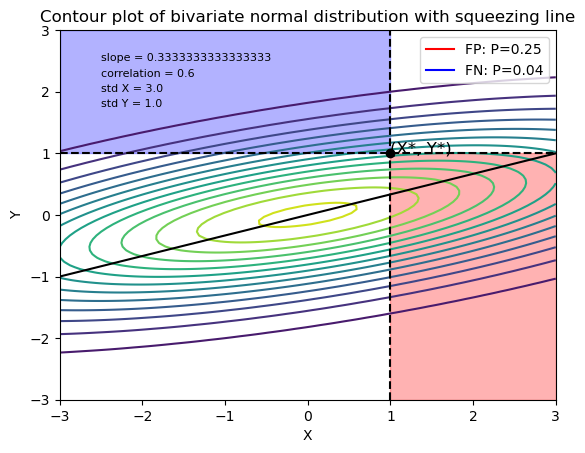

In [166]:
mean, cov = generate_normal_mean_cov(sigma_X=3, rxy=0.6)
plot_countours(mean, cov, x_star=1, y_star=1)

Contour plot with calculation of masses for the different rxy, assuming q(X*) = q(Y*).

In [110]:
sigma_X = 1
sigma_Y = 1
rxy = 0.4
x_star = 1
y_star = 1

fp_prob, fn_prob = prob_fp_fn(x_star, y_star, sigma_X, sigma_Y, rxy)
print(f'False positive probability: {fp_prob}')
print(f'False negative probability: {fn_prob}')

False positive probability: 0.10509196020869141
False negative probability: 0.10509196020869141


Verify that for sigma_x = sigma_y and x_star = y_star, the mass is the same for all rxy.

In [215]:
sigma_X = 1
sigma_Y = 1

records = []
for rxy in np.linspace(0, 1, 20):
    for sigma in np.linspace(0.5, 2, 20):
        for qstar in np.linspace(0, 2, 20):
            x_star = qstar
            y_star = qstar
            fp_prob, fn_prob = prob_fp_fn(x_star, y_star, sigma, sigma, rxy)
            records.append({'rxy': rxy, 'sigma': sigma, 'fp_prob': fp_prob, 'fn_prob': fn_prob})

df = pd.DataFrame(records)
print((df["fp_prob"] - df["fn_prob"]).abs().max())
df.head()

0.0


,rxy,sigma,fp_prob,fn_prob
0,0.0,0.5,0.250000,0.250000
1,0.0,0.5,0.243049,0.243049
2,0.0,0.5,0.223385,0.223385
3,0.0,0.5,0.194224,0.194224
4,0.0,0.5,0.159919,0.159919


New image/calculation suggested by Sorrel:
- combined effect of rxy and the X*-Y* difference on the error probabilities?

In [206]:
# Plot X*-Y*, rxy and color-code accuracy, FP/FN (mark fp/fn=1)
# Assume Y* = 0.25, 0.5, 0.75 and d* = X*-Y* we plot.

N = 100
sigma_X = 1
sigma_Y = 1

y_star = 0.25
dstar = np.linspace(-2, 2, N)
rxy = np.linspace(0, 1, N)

records = []
for y_star_i in [0.25, 0.5, 0.75]:
    for dstar_i in dstar:
        for rxy_i in rxy:
            x_star_i = y_star_i + dstar_i
            fp_prob, fn_prob = prob_fp_fn(x_star_i, y_star_i, sigma_X, sigma_Y, rxy_i)
            acc = 1 - (fp_prob + fn_prob)
            records.append({
                'x_star': x_star_i,
                'd_star': dstar_i,
                'y_star': y_star_i,
                'rxy': rxy_i,
                'fp_prob': fp_prob,
                'fn_prob': fn_prob,
                'acc': acc
            })
df = pd.DataFrame(records)
df["rxy"] = df["rxy"].round(3)
df["d_star"] = df["d_star"].round(3)
df["fp/fn"] = df["fp_prob"] / (df["fn_prob"] + 1e-10)
df["log10_fp/fn"] = np.log10(df["fp/fn"] + 1e-10)
df

,x_star,d_star,y_star,rxy,fp_prob,fn_prob,acc,fp/fn,log10_fp/fn
0,-1.75,-2.0,0.25,0.00,5.747227e-01,0.016075,0.409202,3.575149e+01,1.553294
1,-1.75,-2.0,0.25,0.01,5.743864e-01,0.015739,0.409874,3.649385e+01,1.562220
2,-1.75,-2.0,0.25,0.02,5.740518e-01,0.015405,0.410544,3.726496e+01,1.571301
3,-1.75,-2.0,0.25,0.03,5.737187e-01,0.015072,0.411210,3.806632e+01,1.580541
4,-1.75,-2.0,0.25,0.04,5.733874e-01,0.014740,0.411872,3.889956e+01,1.589945
...,...,...,...,...,...,...,...,...,...
29995,2.75,2.0,0.75,0.96,3.262147e-15,0.223648,0.776352,1.458611e-14,-9.999937
29996,2.75,2.0,0.75,0.97,4.336809e-19,0.223648,0.776352,1.939126e-18,-10.000000
29997,2.75,2.0,0.75,0.98,2.753624e-89,0.223648,0.776352,1.231234e-88,-10.000000
29998,2.75,2.0,0.75,0.99,2.753624e-89,0.223648,0.776352,1.231234e-88,-10.000000


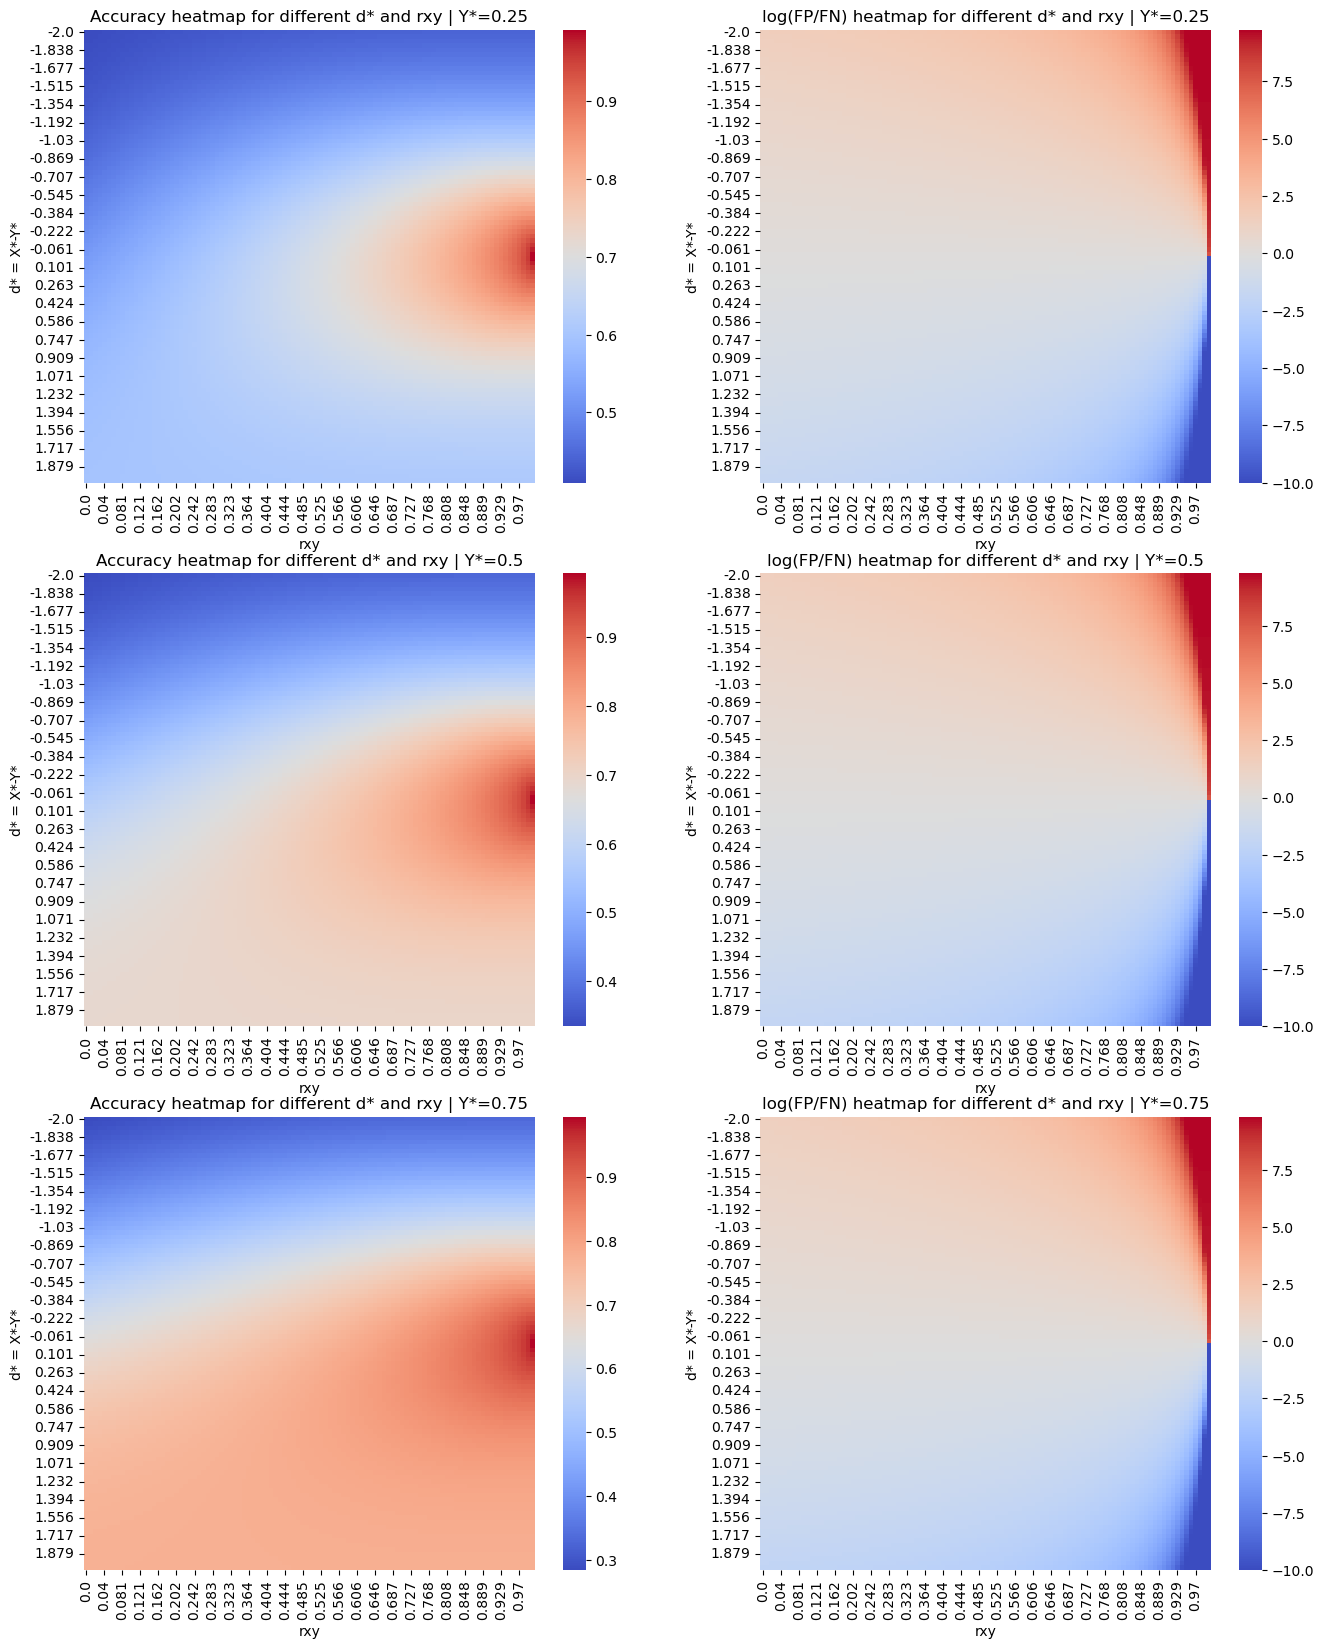

In [209]:
## Heatmap of accuracy

def plot_dstar_performance(df=df):
    
    fig, axs = plt.subplots(3, 2, figsize=(16, 20))
    
    for i, y_star in enumerate([0.25, 0.5, 0.75]):
        
        df_i = df[df['y_star'] == y_star].copy()
        df_pivot = df_i.pivot('d_star', 'rxy', 'acc')

        sns.heatmap(df_pivot, cmap='coolwarm', ax=axs[i][0])
        axs[i][0].set_title(f'Accuracy heatmap for different d* and rxy | Y*={y_star}')
        axs[i][0].set_xlabel('rxy')
        axs[i][0].set_ylabel('d* = X*-Y*')


        df_pivot = df_i.pivot('d_star', 'rxy', 'log10_fp/fn')
        sns.heatmap(df_pivot, cmap='coolwarm', ax=axs[i][1])
        axs[i][1].set_title(f'log(FP/FN) heatmap for different d* and rxy | Y*={y_star}')
        axs[i][1].set_xlabel('rxy')
        axs[i][1].set_ylabel('d* = X*-Y*')

plot_dstar_performance()

Generate and estimate error probabilities. Assume
- X is a proxy for Y.
- q(X*) = q(Y*) = q*

First for one example

In [3]:
q_star = 0.25
rxy = 0.2

# Simulate the data
data = generate_correlated_normal(0, 1, 0, 1, rxy, size=100000)

# Count FP and FN
fp_rate = np.sum((data[:, 0] > q_star) & (data[:, 1] < q_star)) / data.shape[0]
fn_rate = np.sum((data[:, 0] < q_star) & (data[:, 1] > q_star)) / data.shape[0]

For combinations

Text(0.5, 0.98, 'Error rates for various q* and rxy')

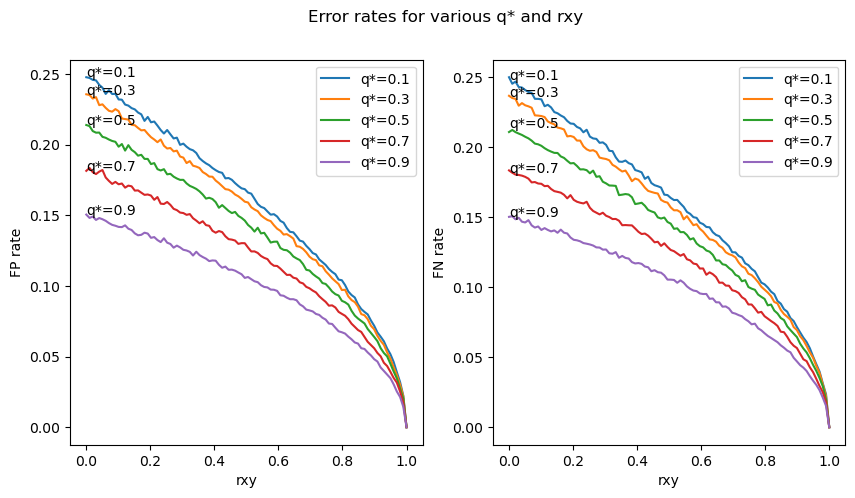

In [4]:
q_stars = [0.1, 0.3, 0.5, 0.7, 0.9]
rxys = np.linspace(0, 1, 100)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for q_star in q_stars:
    fp_rates = []
    fn_rates = []
    for rxy in rxys:
        data = generate_correlated_normal(0, 1, 0, 1, rxy, size=100000)
        fp_rate = np.sum((data[:, 0] > q_star) & (data[:, 1] < q_star)) / data.shape[0]
        fn_rate = np.sum((data[:, 0] < q_star) & (data[:, 1] > q_star)) / data.shape[0]
        fp_rates.append(fp_rate)
        fn_rates.append(fn_rate)
    axs[0].plot(rxys, fp_rates, label=f"q*={q_star}")
    axs[0].text(rxys[0], fp_rates[0], f"q*={q_star}")
    axs[1].plot(rxys, fn_rates, label=f"q*={q_star}")
    axs[1].text(rxys[0], fp_rates[0], f"q*={q_star}")

for ax_i in axs:
    ax_i.set_xlabel("rxy")
    ax_i.legend()

axs[0].set_ylabel("FP rate")
axs[1].set_ylabel("FN rate")

fig.suptitle("Error rates for various q* and rxy")

Fig. 5. Same logic as above, but with difference in q(X*) and q(Y*).

Text(0.5, 0.98, 'Error rates for various q(X*) =/= q(Y*) and rxy')

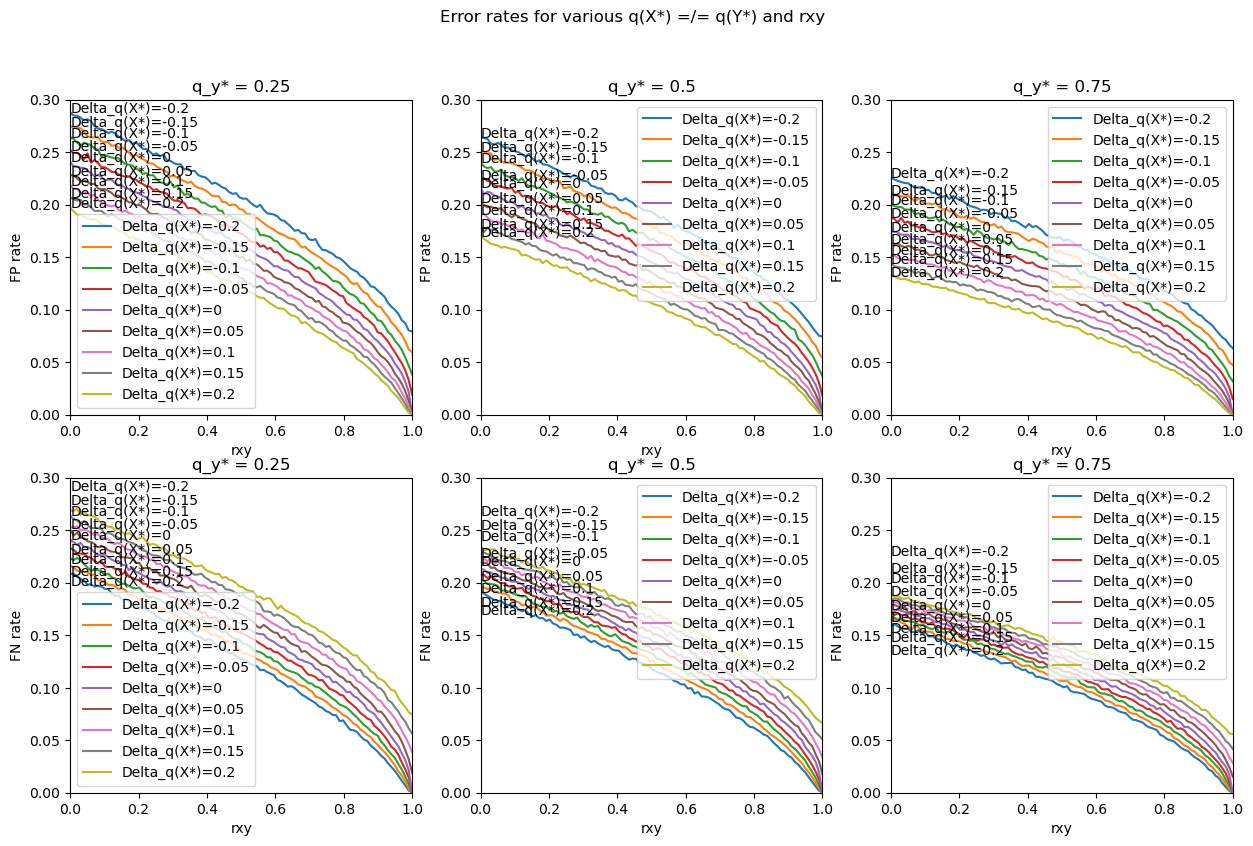

In [5]:
q_y_stars = [0.25, 0.5, 0.75]
q_x_deltas = [-0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2]
rxys = np.linspace(0, 1, 100)

fig, axs = plt.subplots(2, 3, figsize=(15, 9))

for i, q_y_star in enumerate(q_y_stars):
    for j, q_x_delta in enumerate(q_x_deltas):
        
        q_x_star = q_y_star + q_x_delta
        
        fp_rates = []
        fn_rates = []
        for rxy in rxys:
            
            data = generate_correlated_normal(0, 1, 0, 1, rxy, size=100000)
            
            # Assume X is col 0 and Y is col 1
            fp_rate = np.sum((data[:, 0] > q_x_star) & (data[:, 1] < q_y_star)) / data.shape[0]
            fn_rate = np.sum((data[:, 0] < q_x_star) & (data[:, 1] > q_y_star)) / data.shape[0]
            
            fp_rates.append(fp_rate)
            fn_rates.append(fn_rate)
        axs[0][i].plot(rxys, fp_rates, label=f"Delta_q(X*)={q_x_delta}")
        axs[0][i].text(rxys[0], fp_rates[0], f"Delta_q(X*)={q_x_delta}")
        axs[1][i].plot(rxys, fn_rates, label=f"Delta_q(X*)={q_x_delta}")
        axs[1][i].text(rxys[0], fp_rates[0], f"Delta_q(X*)={q_x_delta}")

for i in range(2):
    for j in range(3):
        axs[i][j].set_title(f"q_y* = {q_y_stars[j]}")
        if i == 0:
            axs[i][j].set_ylabel("FP rate")
        else:
            axs[i][j].set_ylabel("FN rate")
        
        axs[i][j].set_xlabel("rxy")    
        axs[i][j].set_xlim(0, 1)
        axs[i][j].set_ylim(0, 0.3)

        axs[i][j].legend()


fig.suptitle("Error rates for various q(X*) =/= q(Y*) and rxy")